In [1]:
%load_ext autoreload
%autoreload 2

# Intialisation


In [3]:
import sys

sys.path.append("../src")  # si tu es dans notebooks/, adapte le chemin si besoin

In [ ]:
import os
from dotenv import load_dotenv
import cv2
from dataset import list_images, batch_get_true_and_pred_masks
from features import (
    colorize_mask,
    custom_colormap,
    CLASS_MAPPING,
)
from plots import (
    display_segmented_images_batch,
    display_triplet_with_scores_2,
    display_segmentation_viz,
    show_image_triplet_with_legend_iou_per_class,
)

from modeling.predict import (
    segment_images_batch,
    segment_image,
    compute_iou_batch,
    compute_iou,
)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random


load_dotenv("../.env")  # Charge les variables d'environnement depuis le fichier .env


True

## Definition des variables du notebook


In [ ]:
image_dir = "../data/raw/top_influenceurs_2024/IMG/"
max_images = 50  # Limite le nombre d'images à traiter pour les tests
# Si tu veux traiter toutes les images, mets max_images=None
api_token = os.getenv("API_TOKEN_HF")
api_url = (
    "https://router.huggingface.co/hf-inference/models/sayeed99/segformer_b3_clothes"
)
image_paths = list_images(image_dir)  # On charge toute les images du dossier
mask_dir = "../data/raw/top_influenceurs_2024/Mask/"


In [ ]:
# Paramètres
SAMPLE_SIZE = 5  # nombre d'images à traiter (None = tout)
SHUFFLE = True  # pour mélanger le dataset ou pas

image_paths_sample = image_paths.copy()
if SHUFFLE:
    random.shuffle(image_paths_sample)
if SAMPLE_SIZE is not None and SAMPLE_SIZE < len(image_paths_sample):
    image_paths_sample = image_paths_sample[:SAMPLE_SIZE]

print(f"Nombre d'images utilisées : {len(image_paths_sample)}")

Nombre d'images utilisées : 5


## 1. Générer prédictions

Je genere les predictions que je stocke dans la variable "masks_pred"


In [28]:
masks_pred = segment_images_batch(image_paths_sample, api_url, api_token, sleep=2)


Batch segmentation: 100%|██████████| 5/5 [00:20<00:00,  4.14s/it]


**Donc ici on va faire matcher les masks predit / les images relatives et les masks de terrain**

=> Pour plus de facilité dans le traitemet la fonction _batch_get_true_and_pred_mask_ retourne une liste de tuple


In [18]:
# 2. Matcher images / masks terrain / masks préd
img_mask_tuples = batch_get_true_and_pred_masks(image_paths, mask_dir, masks_pred)

## 3. Boucler dessus pour visualiser ou scorer


Une première version permettant l’analyse en batch est disponible.  
Ce mode d’analyse est particulièrement adapté pour une évaluation globale, notamment afin d’analyser les scores sur l’ensemble d’un dataset et, par exemple, d’obtenir un tableau de synthèse général.


In [19]:
# Récupérer les masks_true, masks_pred, img_paths depuis img_mask_tuples
img_paths = [
    tpl[0] for tpl in img_mask_tuples
]  # Chemins des images je recupere le premier element de chaque tuple
masks_true = [
    tpl[1] for tpl in img_mask_tuples
]  # Chemins des masques terrain je recupere le deuxieme element de chaque tuple
# Masques prédits, je recupere le troisieme element de chaque tuple
masks_pred = [tpl[2] for tpl in img_mask_tuples]

# Calculer tous les IoU d'un coup
## Explication de cette ecriture :
# compute_iou_batch prend en entrée les masques terrain et prédits, et retourne la
# moyenne des IoU pour chaque image ainsi qu'une liste des IoU par classe.

iou_means, iou_per_class_list = compute_iou_batch(
    masks_true, masks_pred, ignore_class=0
)

# Ensuite, affichage par image (facultatif)
for img_path, mask_true, mask_pred, iou_mean, iou_per_class in zip(
    img_paths, masks_true, masks_pred, iou_means, iou_per_class_list
):
    mask_true_color = colorize_mask(mask_true, custom_colormap)
    mask_pred_color = colorize_mask(mask_pred, custom_colormap)
    print(
        f"{os.path.basename(img_path)} : IoU = {iou_mean:.3f} | par classe : {iou_per_class}"
    )

# Stats globales si tu veux
print(f"Mean IoU global du dataset: {np.nanmean(iou_means):.3f}")

image_15.png : IoU = 0.500 | par classe : {np.uint8(2): np.float64(0.7026639498905743), np.uint8(4): np.float64(0.8157756186282487), np.uint8(6): np.float64(0.8857321044972628), np.uint8(9): np.float64(0.5440019079418078), np.uint8(10): np.float64(0.0), np.uint8(11): np.float64(0.8114803625377643), np.uint8(13): np.float64(0.0), np.uint8(15): np.float64(0.7433110367892977), np.uint8(16): np.float64(0.0)}
image_29.png : IoU = 0.573 | par classe : {np.uint8(2): np.float64(0.8988389470054029), np.uint8(4): np.float64(0.7959914101646385), np.uint8(7): np.float64(0.1099347844499026), np.uint8(9): np.float64(0.1901595744680851), np.uint8(10): np.float64(0.2874859075535513), np.uint8(11): np.float64(0.8970866439651911), np.uint8(12): np.float64(0.7118065045094288), np.uint8(13): np.float64(0.6902239972217399)}
image_28.png : IoU = 0.460 | par classe : {np.uint8(2): np.float64(0.7528816418330053), np.uint8(6): np.float64(0.9531262605889471), np.uint8(7): np.float64(0.9416850386893183), np.uint

Boucle image par image :

Pour notebook exploratoire, inspection manuelle, affichage de chaque résultat, debug “live”.


In [ ]:
for img_path, mask_true, mask_pred in img_mask_tuples:
    # 1. Colorisation pour affichage (si tu veux)
    mask_true_color = colorize_mask(mask_true, custom_colormap)
    mask_pred_color = colorize_mask(mask_pred, custom_colormap)

    # 2. Calcul du score IoU
    iou_mean, iou_per_class = compute_iou(mask_true, mask_pred, ignore_class=0)

    print(
        f"{os.path.basename(img_path)} : IoU = {iou_mean:.3f} | par classe : {iou_per_class}"
    )

image_15.png : IoU = 0.500 | par classe : {np.uint8(2): np.float64(0.7026639498905743), np.uint8(4): np.float64(0.8157756186282487), np.uint8(6): np.float64(0.8857321044972628), np.uint8(9): np.float64(0.5440019079418078), np.uint8(10): np.float64(0.0), np.uint8(11): np.float64(0.8114803625377643), np.uint8(13): np.float64(0.0), np.uint8(15): np.float64(0.7433110367892977), np.uint8(16): np.float64(0.0)}
image_29.png : IoU = 0.573 | par classe : {np.uint8(2): np.float64(0.8988389470054029), np.uint8(4): np.float64(0.7959914101646385), np.uint8(7): np.float64(0.1099347844499026), np.uint8(9): np.float64(0.1901595744680851), np.uint8(10): np.float64(0.2874859075535513), np.uint8(11): np.float64(0.8970866439651911), np.uint8(12): np.float64(0.7118065045094288), np.uint8(13): np.float64(0.6902239972217399)}
image_28.png : IoU = 0.460 | par classe : {np.uint8(2): np.float64(0.7528816418330053), np.uint8(6): np.float64(0.9531262605889471), np.uint8(7): np.float64(0.9416850386893183), np.uint

In [9]:
from features import legend_labels

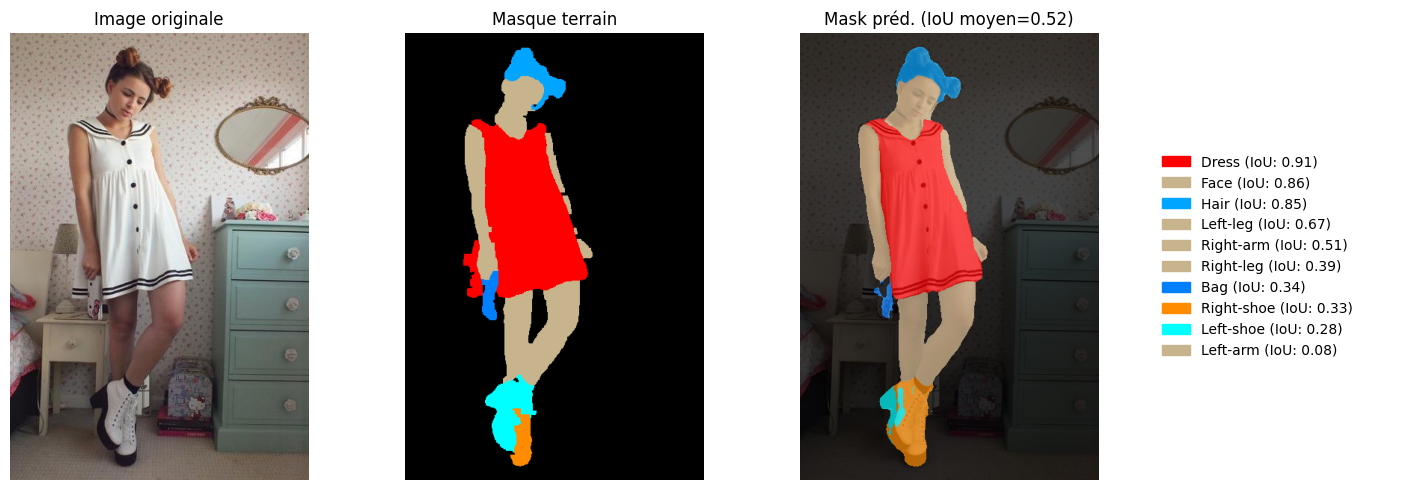

In [13]:
show_image_triplet_with_legend_iou_per_class(
    img_path,
    mask_true,
    mask_pred,
    custom_colormap,
    legend_labels,
    iou_mean,
    iou_per_class,
    overlay_alpha=0.7,  # <- tu peux jouer sur 0.5 à 0.8
)


In [ ]:
all_scores = []
all_iou_per_class = []
for img_path, mask_true, mask_pred in img_mask_tuples:
    iou_mean, iou_per_class = compute_iou(mask_true, mask_pred, ignore_class=0)
    all_scores.append(iou_mean)
    all_iou_per_class.append(iou_per_class)
    print(
        f"{os.path.basename(img_path)} unique classes in mask_true:",
        np.unique(mask_true),
    )

    show_image_triplet_with_legend_iou_per_class(
        img_path,
        mask_true,
        mask_pred,
        custom_colormap,
        legend_labels,
        iou_mean,
        iou_per_class,
        overlay_alpha=0.7,  # <- tu peux jouer sur 0.5 à 0.8
    )


In [ ]:
# Synthèse des scores
global_iou = np.nanmean(all_scores)
# Par classe
all_class_scores = {}
for iou_per_class in all_iou_per_class:  # Suppose que tu les collectes dans ta boucle
    for k, v in iou_per_class.items():
        all_class_scores.setdefault(k, []).append(v)
mean_class_scores = {k: np.nanmean(v) for k, v in all_class_scores.items()}

# Affichage critique
print("\n=== Synthèse Critique du Batch ===")
print(f"Score IoU moyen global : {global_iou:.2f}")

if global_iou >= 0.85:
    print("Excellente segmentation globale.")
elif global_iou >= 0.7:
    print("Bonne segmentation, mais quelques classes posent problème.")
elif global_iou >= 0.5:
    print(
        "Attention : la segmentation est médiocre sur ce batch. Plusieurs erreurs, sans doute des problèmes sur certaines classes."
    )
else:
    print(
        "La segmentation est mauvaise sur ce batch : le modèle n’est pas fiable sur ces données."
    )

print("\nClasses les plus faibles :")
bad_classes = sorted(mean_class_scores.items(), key=lambda x: x[1])[:3]
for c, score in bad_classes:
    print(f"- {legend_labels.get(c, str(c))} : {score:.2f}")

print("\n**Suggestions** :")
print("- Vérifier la qualité des masques de terrain (erreurs d’annotation ?)")
print(
    "- Regarder les images à très faible IoU pour voir s’il y a un pattern d’échec (objets absents, confusion de couleurs, etc)"
)
print(
    "- Eventuellement affiner le modèle avec plus de données sur les classes faibles."
)



=== Synthèse Critique du Batch ===
Score IoU moyen global : 0.57
Attention : la segmentation est médiocre sur ce batch. Plusieurs erreurs, sans doute des problèmes sur certaines classes.

Classes les plus faibles :
- 10 : 0.19
- 13 : 0.22
- 9 : 0.31

**Suggestions** :
- Vérifier la qualité des masques de terrain (erreurs d’annotation ?)
- Regarder les images à très faible IoU pour voir s’il y a un pattern d’échec (objets absents, confusion de couleurs, etc)
- Eventuellement affiner le modèle avec plus de données sur les classes faibles.
